In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Tinput.csv',index_col=[0], parse_dates=[0])
print(df.shape)  # (123, 8)
df.head()

(2359, 2)


,Thucdo,Qden
Date,,
2015-09-16,0.0,91
2015-09-17,3.6,70.77
2015-09-18,6.4,117.44
2015-09-19,0.9,146.9
2015-09-20,0.5,110.87


In [3]:
df.tail()

,Thucdo,Qden
Date,,
2022-02-25,0.0,58.9
2022-02-26,0.0,24.45
2022-02-27,0.0,28.1
2022-02-28,0.0,38.4
2022-03-01,0.0,13


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2359 entries, 2015-09-16 to 2022-03-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Thucdo  2359 non-null   float64
 1   Qden    2359 non-null   object 
dtypes: float64(1), object(1)
memory usage: 55.3+ KB


In [5]:
df['Qden'] = pd.to_numeric(df['Qden'], errors='coerce')

In [6]:
df['Qden'] = df['Qden'].fillna(115)

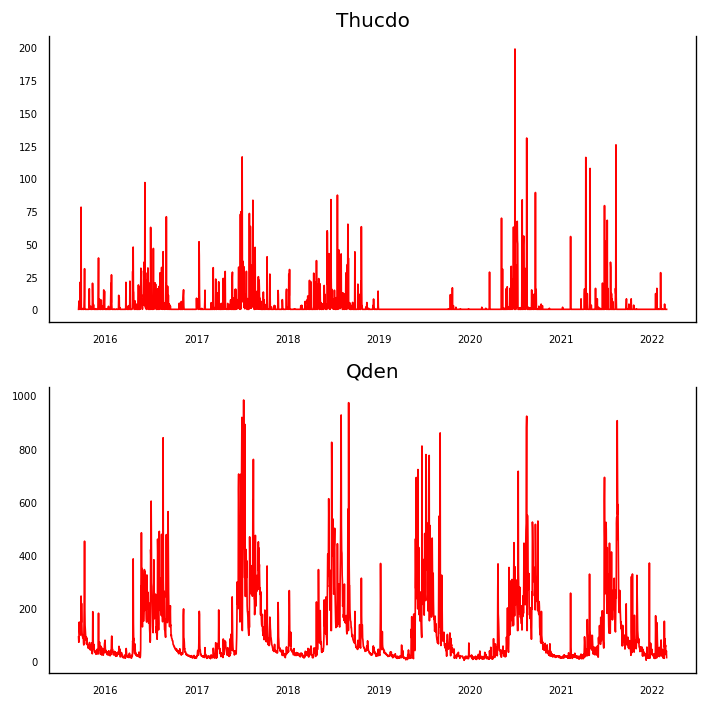

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]] 
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [8]:
#ktra chuỗi dừng

In [9]:
ad_fuller_result_1 = adfuller(df['Thucdo'].diff()[1:])

print('realThucdo')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df['Qden'])

print('realQden')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realThucdo
ADF Statistic: -15.212184512513016
p-value: 5.634486104943394e-28

---------------------

realQden
ADF Statistic: -4.089526891085459
p-value: 0.0010078590959961711


In [10]:
print('Thucdo causes Qden?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['Qden', 'Thucdo']], 4)

print('Qden causes Thucdo?\n')
print('------------------')
granger_2 = grangercausalitytests(df[['Thucdo', 'Qden']], 4)

Thucdo causes Qden?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2823  , p=0.5953  , df_denom=2355, df_num=1
ssr based chi2 test:   chi2=0.2827  , p=0.5950  , df=1
likelihood ratio test: chi2=0.2826  , p=0.5950  , df=1
parameter F test:         F=0.2823  , p=0.5953  , df_denom=2355, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=16.7089 , p=0.0000  , df_denom=2352, df_num=2
ssr based chi2 test:   chi2=33.4889 , p=0.0000  , df=2
likelihood ratio test: chi2=33.2533 , p=0.0000  , df=2
parameter F test:         F=16.7089 , p=0.0000  , df_denom=2352, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.4294 , p=0.0000  , df_denom=2349, df_num=3
ssr based chi2 test:   chi2=46.4260 , p=0.0000  , df=3
likelihood ratio test: chi2=45.9745 , p=0.0000  , df=3
parameter F test:         F=15.4294 , p=0.0000  , df_denom=2349, df_num=3

Granger Causality
number of lags (no zero) 4
ss

In [11]:
df = df[['Thucdo','Qden']]
print(df.shape)

(2359, 2)


In [12]:
train_df=df[:-12]
test_df=df[-12:]

In [17]:
print(train_df.shape)

(2347, 2)


In [13]:
print(test_df.shape)

(12, 2)


In [22]:
print(train_df.diff())

            Thucdo   Qden
Date                     
2015-09-16     NaN    NaN
2015-09-17     3.6 -20.23
2015-09-18     2.8  46.67
2015-09-19    -5.5  29.46
2015-09-20    -0.4 -36.03
...            ...    ...
2022-02-13    -0.4  12.75
2022-02-14     0.0 -16.35
2022-02-15     0.0 -16.30
2022-02-16     0.0   8.85
2022-02-17     0.0   9.30

[2347 rows x 2 columns]


In [23]:
model = VAR(train_df.diff()[1:])

In [24]:
sorted_order=model.select_order(maxlags=40)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.45       14.45   1.877e+06       14.45
1        14.12       14.13   1.352e+06       14.12
2        13.97       14.00   1.170e+06       13.98
3        13.88       13.92   1.067e+06       13.89
4        13.81       13.85   9.921e+05       13.82
5        13.77       13.82   9.534e+05       13.79
6        13.74       13.81   9.299e+05       13.77
7        13.73       13.80   9.182e+05       13.76
8        13.71       13.80   9.025e+05       13.74
9        13.70       13.79   8.907e+05       13.73
10       13.69       13.80   8.833e+05       13.73
11       13.67      13.79*   8.683e+05      13.72*
12       13.67       13.80   8.679e+05       13.72
13       13.67       13.80   8.632e+05       13.72
14       13.67       13.81   8.618e+05       13.72
15       13.66       13.82   8.582e+05       13.72
16       13.66       13.82   8.

In [26]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                           Statespace Model Results                           
Dep. Variable:     ['Thucdo', 'Qden']   No. Observations:                 2347
Model:                         VAR(4)   Log Likelihood              -22660.455
                          + intercept   AIC                          45362.909
Date:                Wed, 15 Mar 2023   BIC                          45483.888
Time:                        11:03:23   HQIC                         45406.972
Sample:                    09-16-2015                                         
                         - 02-17-2022                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.05, 0.28   Jarque-Bera (JB):   410825.45, 75068.42
Prob(Q):                        0.83, 0.60   Prob(JB):                    0.00, 0.00
Heteroskedasticity (H):         1.65, 0.92   Skew:                        6.47, 2.57
Prob(H) (two-sided):            0.

In [27]:
n_forecast = 12
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)

predictions=predict.predicted_mean

In [28]:
predictions.columns=['Thucdo_predicted','Qden_predicted']
predictions

,Thucdo_predicted,Qden_predicted
2022-02-18,1.607905,34.959931
2022-02-19,1.773378,37.811356
2022-02-20,1.946456,43.180934
2022-02-21,2.092270,48.877470
2022-02-22,2.293909,53.509515
2022-02-23,2.393845,57.511910
2022-02-24,2.485366,61.460822
2022-02-25,2.572104,65.207038
2022-02-26,2.654667,68.594785
2022-02-27,2.724112,71.684293


In [29]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

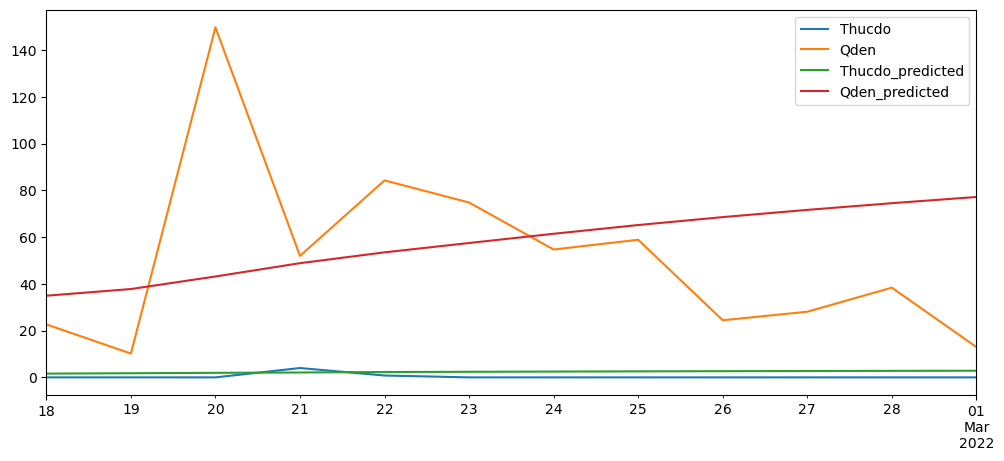

In [30]:
test_vs_pred.plot(figsize=(12,5))

In [31]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

rmse_Qden=math.sqrt(mean_squared_error(predictions['Qden_predicted'],test_df['Qden']))
print('Mean value of Qden is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['Qden']),rmse_Qden))

rmse_Thucdo=math.sqrt(mean_squared_error(predictions['Thucdo_predicted'],test_df['Thucdo']))
print('Mean value of Thucdo is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['Thucdo']),rmse_Thucdo))

Mean value of Qden is : 50.94916666666667. Root Mean Squared Error is :43.68698141607131
Mean value of Thucdo is : 0.4. Root Mean Squared Error is :2.3140180736128952
